# Alpha lifetime

A script to compute alpha lifetime.

In [1]:
from __future__ import print_function, division
%load_ext autoreload
%autoreload 2
import sys
import os
import operator
import functools
import textwrap
import copy
import time
import glob
import math
print("Running on ", time.asctime())

import textwrap
import numpy as np
import pandas as pd
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

from invisible_cities.database import load_db
from invisible_cities.core.system_of_units_c import units
#import invisible_cities.core.system_of_units_c as units
from invisible_cities.core.core_functions import timefunc, flat
import invisible_cities.core.fit_functions as fitf
import invisible_cities.core.mpl_functions as mpl
from invisible_cities.core.mpl_functions import plot_pmt_waveforms, plot_pmt_signals_vs_time_mus, \
              plot_signal_vs_time_mus
from invisible_cities.core.core_functions import in_range

import invisible_cities.reco.tbl_functions as tbl
from invisible_cities.reco.pmaps_functions import plot_s12, width, integrate_charge
import invisible_cities.reco.pmaps_functions as pmapf
from invisible_cities.reco.params import S12Params, ThresholdParams

sys.path.append('/home/brais/Documents/Next/IC/ICARO')

from icaro.core.event_pmaps import EventPmaps, print_s12, print_s2si
from icaro.core.hst_functions import labels, hist, doublehist, hist2d, pdf, scatter, profile_and_scatter,\
                              doublescatter, covariance, reso, gausstext, plot_profile_histogram 
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, print_fit, chi2

from scipy.optimize import curve_fit
from icaro.core.kdst_functions import load_dst, event_rate, profile_and_fit, \
                               profile_and_fit_radial, print_fit, MapXY, chi2,\
                               time_from_timestamp, lifetime

pi = np.pi



Running on  Tue May 23 18:19:02 2017


In [2]:
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-05-23 18:21:07


In [3]:
def plot_options(figsize=(6,6), fontsize=15):
    plt.rcParams["figure.figsize"]          = figsize
    plt.rcParams["font.size"]               = fontsize
    plt.rcParams["figure.max_open_warning"] = 100

In [4]:
plt.rcParams["figure.figsize"]          = 6, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

### Run Parameters

In [32]:
#run_number = 3628
#run_number = 3645
#run_number = 3715
#run_number = 3724
#run_number = 3733
#run_number = 3741
#run_number = 3753
#run_number = 3756
#run_number = 3758
#run_number = 3762
#run_number = 3767
#run_number = 3769
#run_number = 3772
#run_number = 3774
#run_number = 3782
#run_number = 3784
#run_number = 3788
#run_number = 3790
#run_number = 3793
#run_number = 3795
#run_number = 3822
#run_number = 3824
#run_number = 3826
#run_number = 3829
#run_number = 3855
#run_number = 3883

#run_number = 3614

#run_number =  3988
#run_number =  3998
#run_number = 4002
#run_number = 4021
#run_number = 4027
#run_number = 4029
#run_number = 4035
#run_number = 4050
#run_number = 4051
#run_number = 4052
run_number = 4074





In [33]:
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

In [34]:
#ifile = os.path.join(os.environ['IC_DATA'],
#                        'LSC/kdst/{}/kdst_3628_full.h5'.format(run_number))

ifile = os.path.join('/home/brais/Documents/Next/Alpha/data', '{0}/dst_{0}.root.h5'.format(run_number))
                       
print("ifile:", ifile)

ifile: /home/brais/Documents/Next/Alpha/data/4074/dst_4074.root.h5


In [35]:
full = load_dst(ifile)
print(len(full))
full.head()

18420


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.495608e+09,0,1,275.0,356.742310,1966.679146,216450.0,10.966000,2520.960938,...,654887.5,10,438.4375,438.4375,-45.182123,-138.062274,145.267394,-1.887070,7.489001,8.690514
1,2,1.495608e+09,0,1,350.0,254.454712,1558.020130,553100.0,6.887500,4405.873047,...,653462.5,9,100.3625,100.3625,164.532294,65.722908,177.173295,0.380035,7.174754,6.755964
2,3,1.495608e+09,0,1,325.0,248.678024,1510.688494,647975.0,4.177625,9481.593750,...,651512.5,7,3.5375,3.5375,70.593458,-124.938606,143.502932,-1.056491,5.786842,5.185477
3,5,1.495608e+09,0,1,300.0,288.811981,1675.163487,388750.0,9.750625,3250.141113,...,655112.5,9,266.3625,266.3625,105.818062,23.792601,108.459901,0.221166,7.573740,7.565556
4,6,1.495608e+09,0,1,300.0,318.397736,1796.729677,318200.0,8.946063,1177.326172,...,653512.5,5,335.3125,335.3125,-189.105319,-72.921724,202.678069,-2.773549,4.926804,6.792970


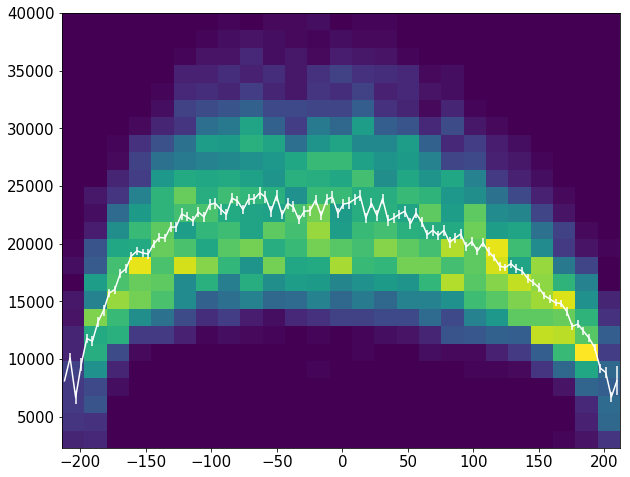

In [36]:
plt.figure(figsize=(10,8))
c = full
c = full[full.Y > -100]
c = c[c.Y <  100]
#c = c[c.Z > 100]
#plt.scatter(c.X, c.S2e)
a = fitf.profileX(c.X, c.S2e, 100)
plt.hist2d(c.X, c.S2e, bins=25)
#plt.ylim((50000,150000))
plt.errorbar(*a, c='white')
plt.show()


In [37]:
fid = full[full.R     <  100*units.mm] # michel sorel cuts

In [38]:
len(fid)

4990

In [39]:
len(full)

18420

In [40]:
r = event_rate(full)

In [41]:
print("Trigger rate: {} evts/s".format(r))

Trigger rate: 4.735900283775816 evts/s


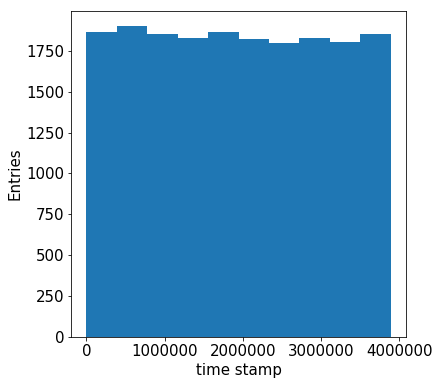

In [42]:
n, bins, patches = plt.hist(1e+3*(full.time - full.time[0]), 10)
labels("time stamp", "Entries")

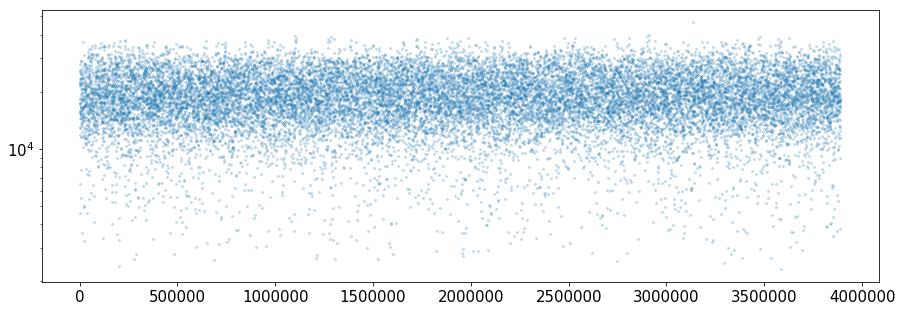

In [43]:
plt.figure(figsize=(15,5))
plt.scatter(1e+3*(full.time - full.time[0]), full.S2e, alpha=.2, s=4)
plt.yscale('log')
plt.show()

In [44]:
st = [datetime.datetime.fromtimestamp(elem).strftime('%Y-%m-%d %H:%M:%S') for elem in full.time]
x = [datetime.datetime.strptime(elem, '%Y-%m-%d %H:%M:%S') for elem in st]

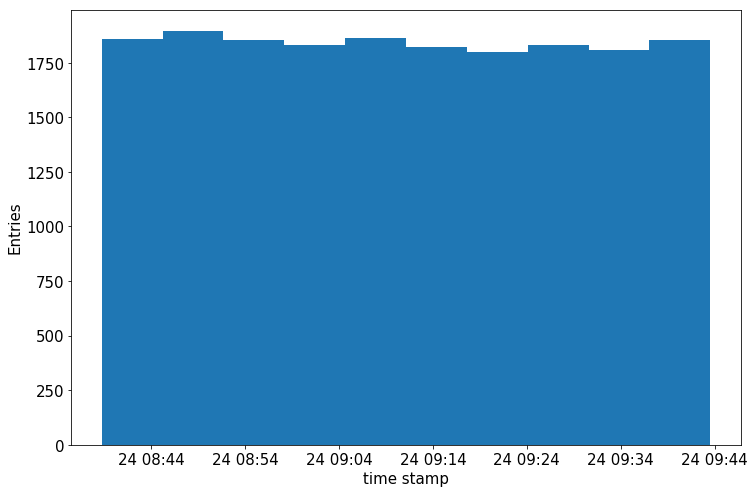

In [45]:
figsize=(12,8)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 1, 1)
nx, bx, _ = plt.hist(x, 10)
labels("time stamp", "Entries")

In [46]:
st = datetime.datetime.fromtimestamp(full.time[-1:]).strftime('%Y-%m-%d %H:%M:%S')

In [47]:
print(st)

2017-05-24 09:43:33


In [48]:
print(full.time.index[-1])

18419


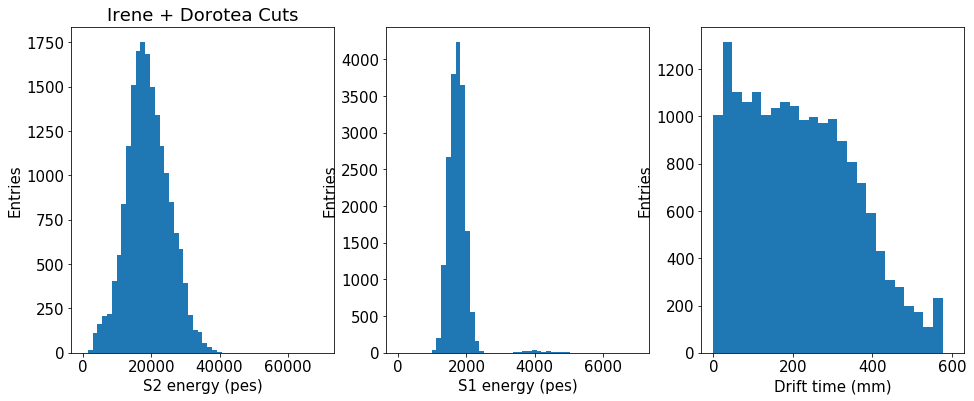

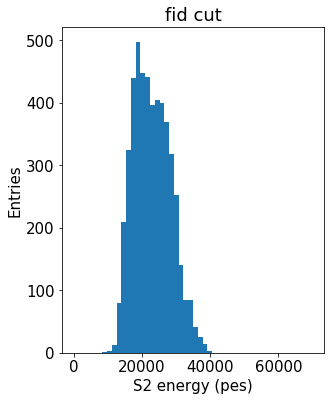

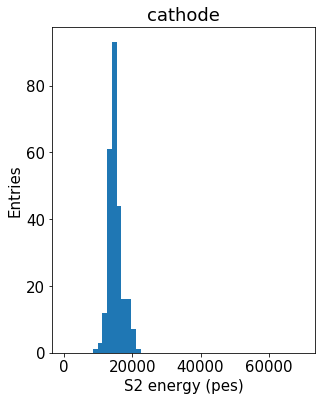

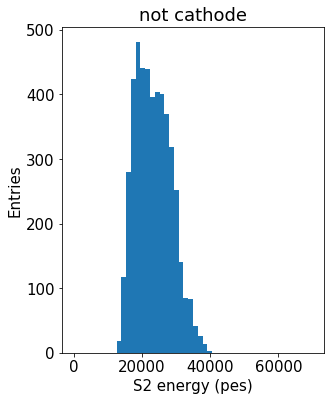

In [49]:
fidc = full[full.R < 100]


figsize=(16,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(full.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('Irene + Dorotea Cuts')


ax = plt.subplot(1, 3, 2)
plt.hist(full.S1e, 50, (0e3,7e3))
labels("S1 energy (pes)", "Entries")

ax = plt.subplot(1, 3, 3)
plt.hist(full.Z, 25, (0,600))
labels("Drift time (mm)", "Entries")

########

#ax = plt.subplot(1, 3, 2)
#plt.hist(fidc.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fidc.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

########

figsize=(16,6)

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist(fid.S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('fid cut')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 2)
plt.hist(fid[in_range(fid.Z, 500, 600)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('cathode')

plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 3)
plt.hist(fid[in_range(fid.Z, 0, 500)].S2e, 50, (0e3,7e4))
labels("S2 energy (pes)", "Entries")
plt.title('not cathode')

#ax = plt.subplot(1, 3, 2)
#plt.hist(fid.S1e, 50, (0e3,7e3))
#labels("S1 energy (pes)", "Entries")

#ax = plt.subplot(1, 3, 3)
#plt.hist(fid.Z, 25, (0,600))
#labels("Drift time (mm)", "Entries")

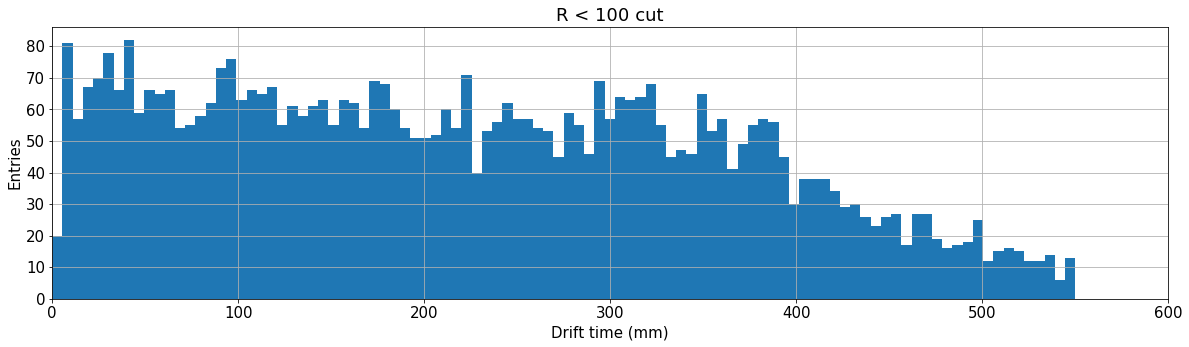

In [50]:
plt.figure(figsize=(20,5))
b = plt.hist(fid.Z, 100, (0, 550))
plt.xlim(0,600)
plt.grid(True)
labels("Drift time (mm)", "Entries")
plt.title('R < 100 cut')




### Dependence with Z all alphas

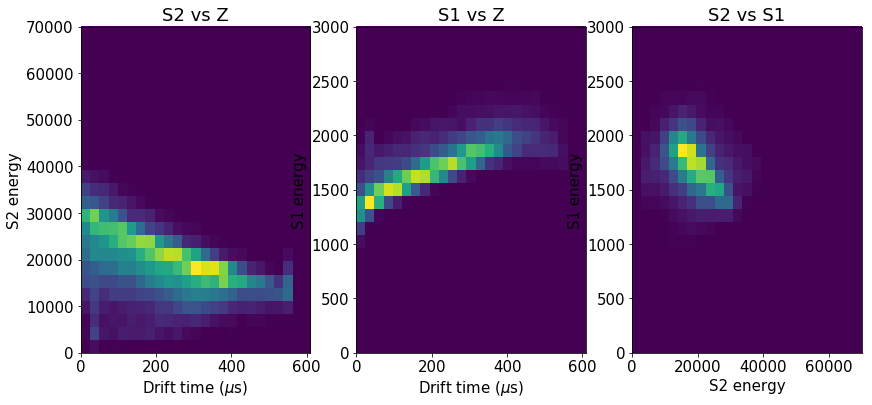

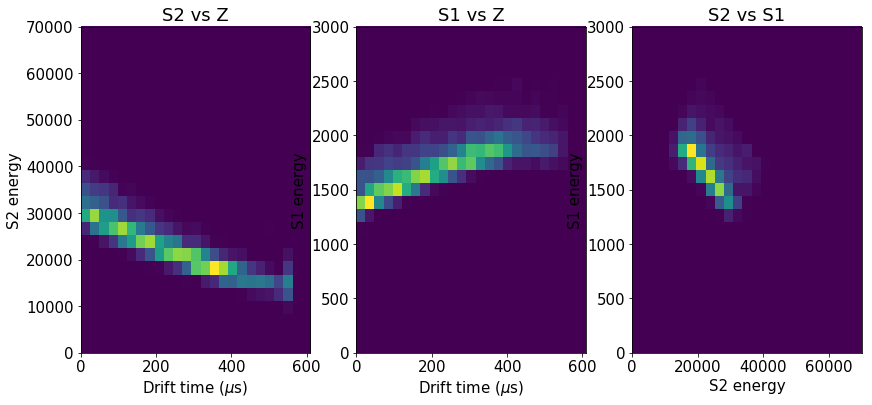

In [51]:
zrange =   0, 610
S2range = 0, 7e4
S1range = 0, 3e3

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(full.Z, full.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(full.Z, full.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(full.S2e, full.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')

figsize=(14,6)
plt.figure(figsize=figsize)
ax = plt.subplot(1, 3, 1)
plt.hist2d(fid.Z, fid.S2e, (25, 25), range=(zrange, S2range))
labels("Drift time ($\mu$s)", "S2 energy")
plt.title('S2 vs Z')

ax = plt.subplot(1, 3, 2)
plt.hist2d(fid.Z, fid.S1e, (25, 25), range=(zrange, S1range))
labels("Drift time ($\mu$s)", "S1 energy")
plt.title('S1 vs Z')

ax = plt.subplot(1, 3, 3)
plt.hist2d(fid.S2e, fid.S1e, (25, 25), range=(S2range, S1range))
labels("S2 energy", "S1 energy")
plt.title('S2 vs S1')



### Fiducial volume

In [52]:
#core = blk[blk.R < 100]
core = fid
print("Ratio wrt full:", len(core)/len(full))

cathode = full[full.Z > 500]
#core2 = core2[core2.Z < 500]

#core= fid

Ratio wrt full: 0.2709011943539631


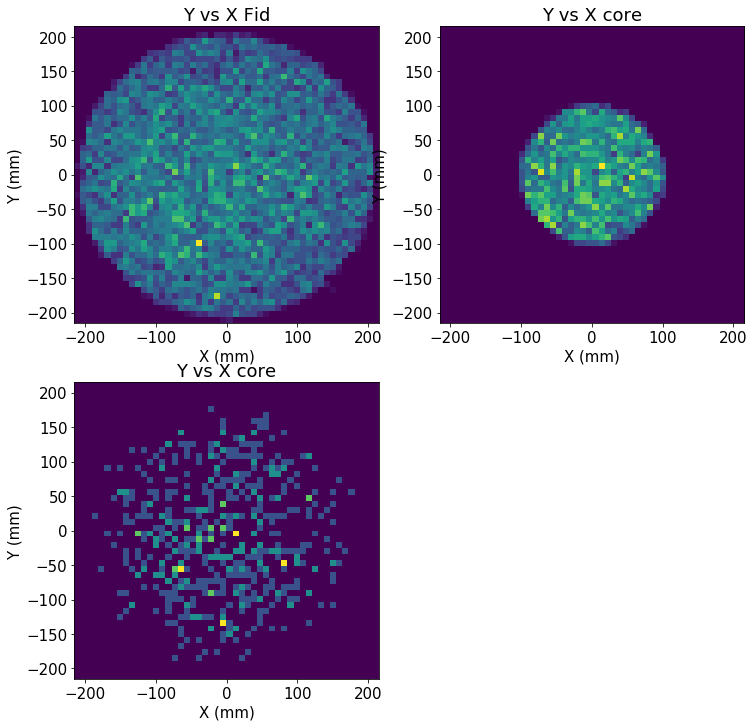

In [53]:
xrange = -215, 215
yrange = -215, 215

figsize=(12,12)
plt.figure(figsize=figsize)
ax = plt.subplot(2, 2, 1)

plt.hist2d(full.X, full.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X Fid')

ax = plt.subplot(2, 2, 2)

plt.hist2d(core.X, core.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

ax = plt.subplot(2, 2, 3)
plt.hist2d(cathode.X, cathode.Y, (50, 50), range=(xrange, yrange))
labels("X (mm)", "Y (mm)")
plt.title('Y vs X core')

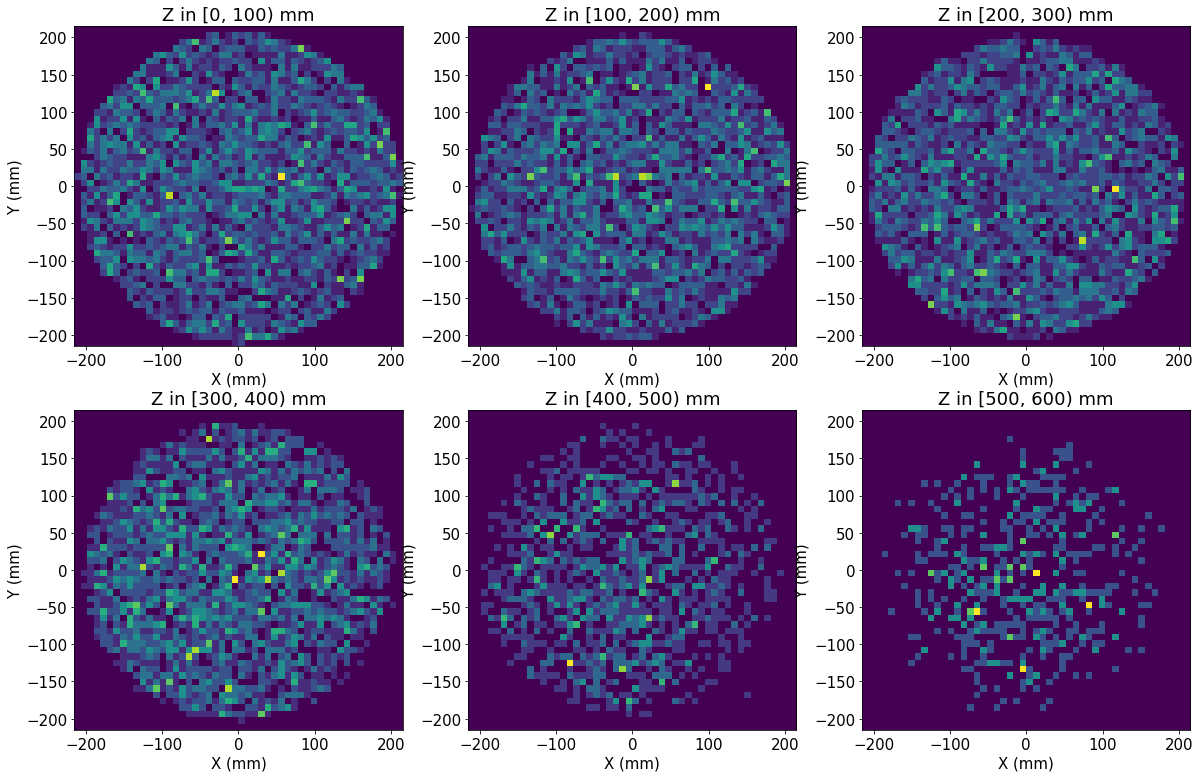

In [54]:
figsize=(20,20)
plt.figure(figsize=figsize)
ax = plt.subplot(3, 3, 1)

for i in range(6):

    ax = plt.subplot(3, 3, i+1)
    plt.hist2d(full[in_range(full.Z, i*100, (i+1)*100)].X, full[in_range(full.Z, i*100, (i+1)*100)].Y,
               (50, 50), range=(xrange, yrange))
    labels("X (mm)", "Y (mm)")
    plt.title('Z in [' + str(i*100) + ', ' + str((i+1)*100) + ') mm')

### Z correction for bulk 

#### S2

fit par[0] = 32182.630851118 error = 121.20927528450551
fit par[1] = -641.0303346572894 error = 6.091478979826426
degrees of freedom = 2
chi2 = 1.0063348179117428


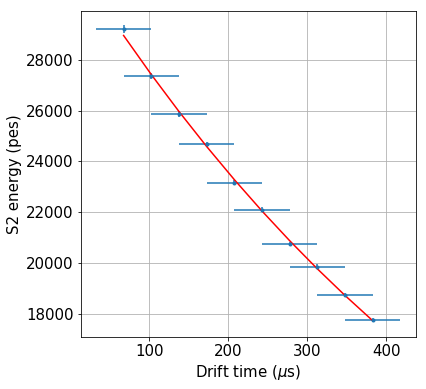

In [63]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 10
F, x, y, sy = profile_and_fit(core.Z, core.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))
-F.values[1]
print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [56]:
-F.values[1]
F

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7fa8c037d0d0>, values=array([ 32182.63085112,   -641.03033466]), errors=array([ 121.20927528,    6.09147898]), chi2=0.66070084974804311, pvalue=0.70562896382529738)

#### Constrain fiducial in z

In [57]:
cz = core[in_range(core.Z ,50, 400)]
print("Ratio wrt full:", len(cz)/len(full))

Ratio wrt full: 0.1993485342019544


#### Fit S2 in fiducial 

fit par[0] = 24729.505953215186 error = 177.12137804409457
fit par[1] = -776.5106644552873 error = 16.58750266911887
degrees of freedom = 2
chi2 = 1.0673851045849458


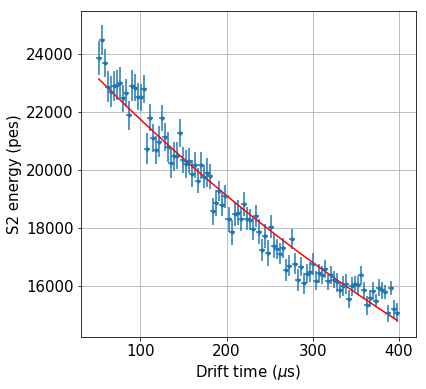

In [61]:
zrange =   50, 400
Erange = 1e+3, 70e3
nbins = 100
F, x, y, sy = profile_and_fit(full.Z, full.S2e, 
                    xrange=zrange, 
                    yrange=Erange, 
                    nbins=nbins, 
                    fitpar=(50000,-300), label=("Drift time ($\mu$s)", "S2 energy (pes)"))

print_fit(F)
print('chi2 = {}'.format(chi2(F, x, y, sy)))

In [59]:
F

FitFunction(fn=<function fit.<locals>.<lambda> at 0x7fa8aa82f400>, values=array([ 24701.13844915,   -777.63846811]), errors=array([ 441.331165  ,   41.54034371]), chi2=9.3229674286790747, pvalue=1.3328560133409045e-11)

### S2 corrections

In [153]:
st0 = time_from_timestamp(full.time[0])
st1 = time_from_timestamp(full.time[-1:])
print('t0 = {} t1 = {}'.format(st0,st1))

t0 = 2017-05-22 10:55:03 t1 = 2017-05-22 11:16:55


using data set with length 1587
t0 = 2017-05-22 10:55:04 (index = 0) t1 = 2017-05-22 11:16:55 (index = 1587)
bin length = 317
 ---fit over events between 0 and 316
time0 = 2017-05-22 10:55:04 time1 = 2017-05-22 10:59:17
size of time leg = 316
fit par[0] = 28073.861027964114 error = 206.76936689965103
fit par[1] = -595.3942436293881 error = 9.880502160437535
degrees of freedom = 2
chi2 = 0.5444348746660569
 ---fit over events between 317 and 633
time0 = 2017-05-22 10:59:18 time1 = 2017-05-22 11:03:16
size of time leg = 316
fit par[0] = 27861.214543257327 error = 533.634141076927
fit par[1] = -641.6849974077038 error = 30.239062929312578
degrees of freedom = 2
chi2 = 1.1343803211740766
 ---fit over events between 634 and 950
time0 = 2017-05-22 11:03:17 time1 = 2017-05-22 11:07:49
size of time leg = 316
fit par[0] = 28134.934204035562 error = 552.7457191442772
fit par[1] = -610.8232932971961 error = 31.098988864940104
degrees of freedom = 2
chi2 = 1.59816497499088
 ---fit over events betw

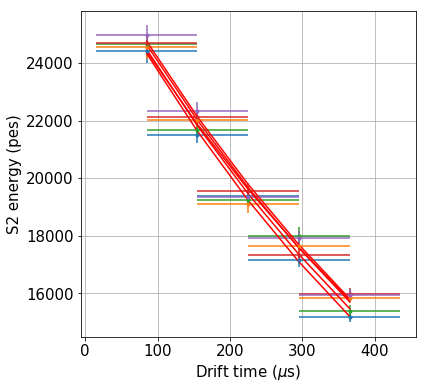

In [154]:
CHI2, LAMBDA, ELAMBDA, TSTAMP, TIME = lifetime(dst=core, zrange=(50,400), Erange=(1e+3, 80e3), nbins=5)

In [155]:
plot_options()

In [156]:
TSTAMP

['2017-05-22 10:59:17',
 '2017-05-22 11:03:16',
 '2017-05-22 11:07:49',
 '2017-05-22 11:11:59',
 '2017-05-22 11:16:54']

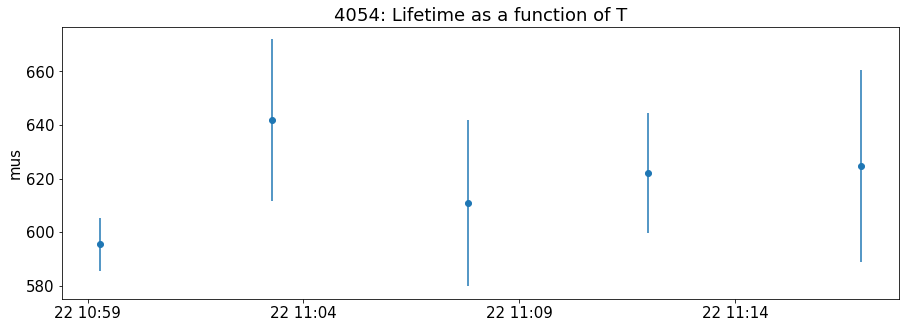

In [157]:
figsize=(15,5)
plt.figure(figsize=figsize)
plt.errorbar(TIME, -np.array(LAMBDA), yerr=ELAMBDA, linestyle='none', fmt='o')
plt.ylabel('mus')
plt.title('{}: Lifetime as a function of T'.format(run_number))
plt.show()



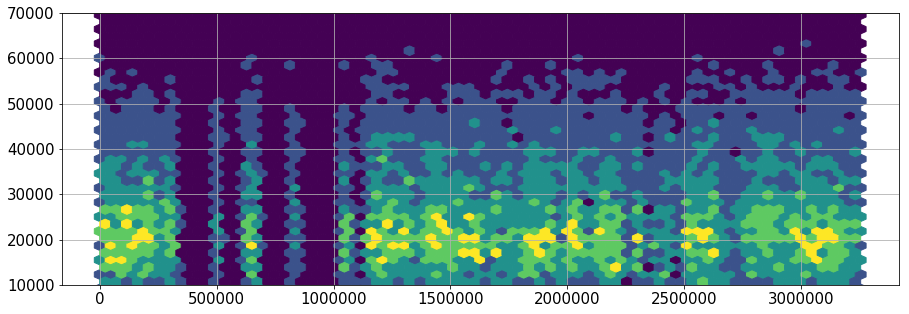

In [100]:
plt.figure(figsize=figsize)
plt.hexbin(1e+3*(full.time - full.time[0]), full.S2e, bins=5, gridsize=70)
#plt.yscale('log')
plt.ylim(10000,70000)
#plt.ylabel('S2e')
plt.grid(True)
plt.show()